In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from imblearn.over_sampling import SMOTE

Chargement du dataset

In [2]:
allocine_df = pd.read_pickle("./dataset_allocine.pickle")
allocine_df.head()

,commentaire,note
0,Décevant !<br/>Napoléon vu par Ridley Scott es...,1.0
1,Ça se laisse voir sans grand ennui mais pour q...,2.0
2,Succession de cartes postales sympathiques san...,1.0
3,"Film politisé et non-objectif, qui personnifie...",1.5
4,Ce film est une insulte à l'égard du peuple fr...,1.0


Distribution des commentaires

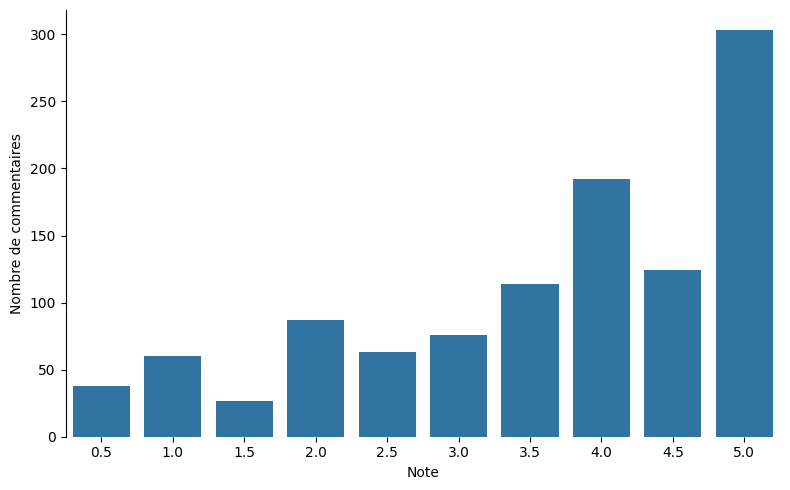

In [3]:
plt.figure(figsize=(8,5))

ax = sns.countplot(data=allocine_df, x='note')
ax.set(xlabel='Note', ylabel='Nombre de commentaires')

# Mise en forme finale du graphique
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Sauvegarde du graphique
# fig = ax.get_figure()
# fig.savefig('images/distribution_commentaires.png', dpi=200)

Retirer les éléments de ponctuation

In [4]:
REMPLACE_SANS_ESPACE = re.compile("[;:!\'?,\"()\[\]]|<br\s*/>")
REMPLACE_AVEC_ESPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|[.]")
PUR_NOMBRE = re.compile("[0-9]")

def preprocess_reviews(reviews):
    reviews = [PUR_NOMBRE.sub("", line.lower()) for line in reviews] # retire les nomre (comme les années)
    reviews = [line.replace('\n', ' ')  for line in reviews] # Retire les \n (retours chariots)
    reviews = [REMPLACE_SANS_ESPACE.sub("", line.lower()) for line in reviews]
    reviews = [REMPLACE_AVEC_ESPACE.sub(" ", line) for line in reviews]
    return reviews

allocine_df['commentaire'] = pd.DataFrame(preprocess_reviews(allocine_df['commentaire']))

allocine_df.head()

,commentaire,note
0,décevant napoléon vu par ridley scott est à la...,1.0
1,ça se laisse voir sans grand ennui mais pour q...,2.0
2,succession de cartes postales sympathiques san...,1.0
3,film politisé et non objectif qui personnifie ...,1.5
4,ce film est une insulte à légard du peuple fra...,1.0


Equilibrer le dataset

In [5]:
# seed = 100
# k = 1

# # séparation des labels et des targets
# targets = allocine_df.loc[:, allocine_df.columns != 'note']
# labels = allocine_df.note
# # targets.head()
# # labels.head()

# sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)
# targets_res, labels_res = sm.fit_resample(targets, labels)

# balanced_allocine_df = pd.concat([pd.DataFrame(targets_res), pd.DataFrame(labels_res)], axis=1)

In [6]:
# plt.figure(figsize=(8,5))

# ax = sns.countplot(data=balanced_allocine_df, x='note')
# ax.set(xlabel='Note', ylabel='Nombre de commentaires')

# # Mise en forme finale du graphique
# sns.despine(bottom=True)
# plt.tight_layout(h_pad=2)